In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.models import SVGP, SGPR
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints

import invgp
from invgp.models.SampleSVGP import SampleSVGP
import invgp.kernels.orbits as orbits
from invgp.inducing_variables.invariant_convolution_domain import StochasticConvolvedInducingPoints

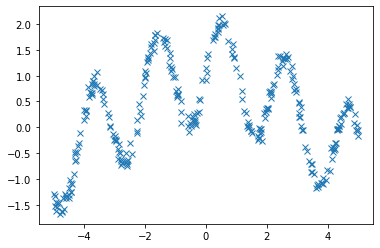

In [2]:
pX = np.linspace(-10.0, 10.0, 300)[:, None]
X = np.random.uniform(-5, 5, 300)[:, None]
Y = np.sin(3 * X) + 0.1  +  np.cos(0.5 * X) + np.random.randn(*X.shape) * 0.1
Z = np.linspace(-5, 5, 50)[:, None]

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

plt.plot(X,Y ,"x")

In [3]:
from gpflow.covariances.dispatch import Kuf, Kuu
from gpflow.kernels import SquaredExponential
from gpflow.utilities.ops import square_distance

class GaussianNoiseInvariant(SquaredExponential):
    def __init__(self, base_variance=1.0, base_lengthscales=1.0, orbit_variance=1.0):
        self.base_variance = gpflow.Parameter(base_variance, transform=gpflow.utilities.bijectors.positive())
        self.base_lengthscales = gpflow.Parameter(base_lengthscales, transform=gpflow.utilities.bijectors.positive())
        self.orbit_variance = orbit_variance
        super().__init__()

    @property
    def lengthscales(self):
        return (self.base_lengthscales ** 2.0 + 2 * self.orbit_variance) ** 0.5

    @lengthscales.setter
    def lengthscales(self, x):
        pass

    @property
    def variance(self):
        return (self.base_lengthscales ** 2.0 / self.lengthscales ** 2.0) ** 0.5 * self.base_variance

    @variance.setter
    def variance(self, x):
        pass


class GaussianNoiseInvariantInducing(gpflow.inducing_variables.InducingPoints):
    pass


@Kuu.register(GaussianNoiseInvariantInducing, GaussianNoiseInvariant)
def Kuu_temp(inducing_variable, kernel, *, jitter=0.0):
    X_scaled = inducing_variable.Z / kernel.base_lengthscales
    r2 = square_distance(X_scaled, None)
    return kernel.base_variance * tf.exp(-0.5 * r2) + jitter * tf.eye(len(inducing_variable), dtype=r2.dtype)


@Kuf.register(GaussianNoiseInvariantInducing, GaussianNoiseInvariant, object)
def Kuf_temp(inducing_variable, kernel, Xnew):
    ls = (kernel.base_lengthscales ** 2.0 + kernel.orbit_variance) ** 0.5
    X_scaled = Xnew / ls
    Z_scaled = inducing_variable.Z / ls
    r2 = square_distance(Z_scaled, X_scaled)
    return kernel.base_variance * (kernel.base_lengthscales ** 2.0 / ls ** 2.0) ** 0.5 * tf.exp(-0.5 * r2)

In [4]:
orbit_variance = 0.1

det_k = GaussianNoiseInvariant(orbit_variance=orbit_variance)

In [5]:
SVGPmodel = SVGP(det_k, likelihood = gpflow.likelihoods.Gaussian(), inducing_variable=GaussianNoiseInvariantInducing(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = SVGPmodel.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGPmodel.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

SVGPelbo = SVGPmodel.elbo((X,Y))

Step: 0, Mini batch elbo: -525.7690514986036
Step: 50, Mini batch elbo: -351.7720247857554
Step: 100, Mini batch elbo: -308.0101178260792
Step: 150, Mini batch elbo: -176.65445089486283
Step: 200, Mini batch elbo: -65.22817383084359
Step: 250, Mini batch elbo: 23.51760523505314
Step: 300, Mini batch elbo: 95.77652119129912
Step: 350, Mini batch elbo: 148.0494362075405
Step: 400, Mini batch elbo: 178.75945802098147
Step: 450, Mini batch elbo: 193.0930009375991
Step: 500, Mini batch elbo: 197.33625958164882
Step: 550, Mini batch elbo: 199.316708615824
Step: 600, Mini batch elbo: 199.50365581389218
Step: 650, Mini batch elbo: 199.8384286703306
Step: 700, Mini batch elbo: 199.6981903909562
Step: 750, Mini batch elbo: 199.89423175272455
Step: 800, Mini batch elbo: 199.68620107516165
Step: 850, Mini batch elbo: 199.22732646142697
Step: 900, Mini batch elbo: 199.20656601944822
Step: 950, Mini batch elbo: 199.878608366525
Step: 1000, Mini batch elbo: 200.19199655041402
Step: 1050, Mini batch e

In [6]:
orbit_samples = [20, 40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
g_samples = 10
elbo_means = []
elbo_sds = []

for os in orbit_samples:
    stoch_k = invgp.kernels.StochasticInvariant(
        basekern=gpflow.kernels.SquaredExponential(variance = det_k.base_variance, lengthscales = det_k.base_lengthscales),
        orbit=orbits.GaussianNoiseOrbit(variance=orbit_variance,
                                  minibatch_size = os))

    sample_model = SampleSVGP(stoch_k,
                              inducing_variable = StochasticConvolvedInducingPoints(SVGPmodel.inducing_variable.Z), 
                              num_data = len(X),
                              likelihood = gpflow.likelihoods.Gaussian(variance = SVGPmodel.likelihood.variance),
                              q_mu = SVGPmodel.q_mu.numpy(),
                              q_sqrt = SVGPmodel.q_sqrt.numpy(),
                              matheron_sampler = True, num_samples = g_samples)
    container = []
    for it in range(20):
        elbo = sample_model.elbo((X,Y))
        container.append(elbo.numpy())
    elbo_means.append(np.mean(container))
    elbo_sds.append(np.std(container))

In [7]:
elbo_means

[-356.3910122976372,
 -73.75056563554399,
 15.425147720116609,
 59.06531217624886,
 92.05244558427232,
 144.89398964275858,
 165.44891959692848,
 171.19676086308726,
 177.6007999244652,
 179.10305932548994,
 183.20552369290417,
 191.54484564702494,
 187.45423157336523,
 189.86482419771124]

<ErrorbarContainer object of 3 artists>

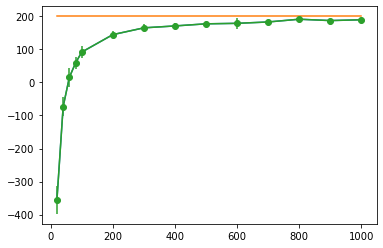

In [8]:
fig, ax = plt.subplots()
plt.plot(orbit_samples, elbo_means, "-")
plt.plot(orbit_samples, SVGPelbo.numpy() * np.ones(len(orbit_samples)))
ax.errorbar(orbit_samples, elbo_means,
            yerr=elbo_sds,
            fmt='-o')

## Non-Gaussian likelihood


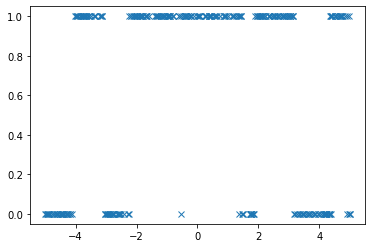

In [9]:
pX = np.linspace(-10.0, 10.0, 300)[:, None]
#X = np.random.uniform(-5, 5, 300)[:, None]
#Y = np.sin(3 * X) + 0.1  +  np.cos(0.5 * X) + np.random.randn(*X.shape) * 0.1
Y = (Y > 0).astype(int)
Z = np.linspace(-5, 5, 50)[:, None]

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

plt.plot(X,Y ,"x")

In [10]:
orbit_variance = 0.1

det_k = GaussianNoiseInvariant(orbit_variance=orbit_variance)

In [11]:
SVGPmodel = SVGP(det_k, likelihood = gpflow.likelihoods.Softmax(num_classes = 2), 
                 num_data = len(X),
                 num_latent_gps = 2,
                 inducing_variable=GaussianNoiseInvariantInducing(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = SVGPmodel.training_loss_closure(train_iter, compile=False) # Compile not working for softmax-likelihood
optimizer = tf.keras.optimizers.Adam(0.01)
#@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGPmodel.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

SVGPelbo = SVGPmodel.elbo((X,Y))

Step: 0, Mini batch elbo: -258.1142993673033
Step: 50, Mini batch elbo: -161.2716395615605
Step: 100, Mini batch elbo: -127.51862350973516
Step: 150, Mini batch elbo: -108.39739146944605
Step: 200, Mini batch elbo: -103.35224980357657
Step: 250, Mini batch elbo: -100.18934024999265
Step: 300, Mini batch elbo: -98.87335682870092
Step: 350, Mini batch elbo: -96.833859911337
Step: 400, Mini batch elbo: -95.36759037926062
Step: 450, Mini batch elbo: -93.26707847840264
Step: 500, Mini batch elbo: -92.35242696702522
Step: 550, Mini batch elbo: -91.55682187213567
Step: 600, Mini batch elbo: -90.67365390888229
Step: 650, Mini batch elbo: -90.58307212418865
Step: 700, Mini batch elbo: -89.30868381730633
Step: 750, Mini batch elbo: -89.33353009591735
Step: 800, Mini batch elbo: -89.44149358661647
Step: 850, Mini batch elbo: -88.25722232835523
Step: 900, Mini batch elbo: -88.40094412914667
Step: 950, Mini batch elbo: -87.6144504877947
Step: 1000, Mini batch elbo: -87.46107166247401
Step: 1050, Mi

In [12]:
orbit_samples = [20, 40, 60, 80, 100, 200, 300]
g_samples = 10
elbo_means = []
elbo_sds = []

for os in orbit_samples:
    stoch_k = invgp.kernels.StochasticInvariant(
        basekern=gpflow.kernels.SquaredExponential(variance = det_k.base_variance, lengthscales = det_k.base_lengthscales),
        orbit=orbits.GaussianNoiseOrbit(variance=orbit_variance,
                                  minibatch_size = os))

    sample_model = SampleSVGP(stoch_k,
                              inducing_variable = StochasticConvolvedInducingPoints(SVGPmodel.inducing_variable.Z), 
                              num_data = len(X),
                              likelihood = gpflow.likelihoods.Softmax(num_classes = 2),
                              num_latent_gps = 2,
                              q_mu = SVGPmodel.q_mu.numpy(),
                              q_sqrt = SVGPmodel.q_sqrt.numpy(),
                              matheron_sampler = True, num_samples = g_samples)
    container = []
    for it in range(20):
        elbo = sample_model.elbo((X,Y))
        container.append(elbo.numpy())
    elbo_means.append(np.mean(container))
    elbo_sds.append(np.std(container))

In [13]:
elbo_means

[-98.0207762175261,
 -88.97427528891299,
 -87.21535867262715,
 -86.2147002502381,
 -84.86420994761633,
 -82.92280198632328,
 -83.29434229191263]

<ErrorbarContainer object of 3 artists>

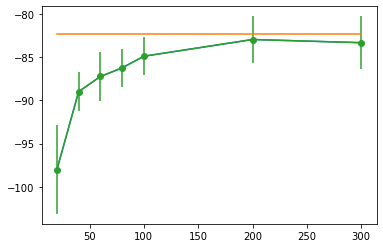

In [14]:
fig, ax = plt.subplots()
plt.plot(orbit_samples, elbo_means, "-")
plt.plot(orbit_samples, SVGPelbo.numpy() * np.ones(len(orbit_samples)))
ax.errorbar(orbit_samples, elbo_means,
            yerr=elbo_sds,
            fmt='-o')